In [1]:
from torchcore.dnn.networks.backbone.resnet import ResNet
from torchcore.dnn.networks.necks.feature_pyramid_network import FPN
from torchcore.dnn.networks.heads.fcos_head import FCOSFeatureHead

backbone = ResNet(depth=50,
                returned_layers=[1,2,3,4],
                norm_layer_cfg=dict(type='GN', num_groups=32),
                init_cfg=dict(type='pretrained'))
neck = FPN(in_channels_list=[0, 512, 1024, 2048],
               out_channels=256,
               extra_blocks='last_level_p6p7')

head = FCOSFeatureHead(in_channels=256,
                num_classes=46,
                norm_layer_cfg=dict(type="GN", num_groups=32),
                strides=(8,16,32,64,128),
                centerness=True,
                center_with_cls=True)




init from pretrained model


In [2]:
from torchcore.dnn.networks.detection_heads.fcos_head import FCOSHead
head_cfg = dict(
                type='FCOSFeatureHead',
                in_channels=256,
                num_classes=46,
                strides=(8, 16, 32, 64, 128),
                norm_layer_cfg=dict(type="GN", num_groups=32),
                centerness=True,
                center_with_cls=True
)
det_head = FCOSHead(head_cfg, num_class=46)

In [1]:
from torchcore.util import Config
from torchcore.dnn.networks.detectors.build import build_detector
cfg = 'configs/fcos/fcos_resnet50_fpn_fashion_pedia.py'
config = Config.fromfile(cfg)
model=build_detector(config.model)

init from pretrained model


In [2]:
from train import load_checkpoint
model_path = '/home/dsv/qida0163/Vision/data/fcos/fcos_resnet50_fpn_fashion_pedia_20211102_fcos_resnet50/checkpoints/checkpoint_20211102_fcos_resnet50_step_160000.pth'
load_checkpoint(model, model_path, 'cpu')

Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/fcos/fcos_resnet50_fpn_fashion_pedia_20211102_fcos_resnet50/checkpoints/checkpoint_20211102_fcos_resnet50_step_160000.pth


In [3]:
from torchcore.data.datasets.build import build_dataloader
from torchcore.util.config import Config
cfg_path = 'configs/fcos/fcos_resnet50_fpn_fashion_pedia.py'
#cfg_path = 'configs/fcos/fcos_resnet50_fpn_coco.py'
cfg = Config.fromfile(cfg_path)
cfg.dataloader_val.batch_size=1
val_dataset_loader = build_dataloader(cfg.dataloader_val,distributed=False)

In [ ]:

%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
import matplotlib.pyplot as plt
dataset= val_dataset_loader.dataset
fpn_layer = 1
j = 0
for i, (inputs, targets) in enumerate(val_dataset_loader):
    class_hp, bbox_hp, centerness_hp = model.get_heatmaps(inputs, targets)
    input, target = dataset[i]
    im = input['data']
    boxes = target['boxes']
    labels= target['labels']
    draw_plain_boxes(im, boxes)
    #heatmap = class_hp[fpn_layer][0].detach().numpy()
    heatmap = centerness_hp[fpn_layer][0].detach().numpy()
    mixim=visulize_colored_heatmaps_with_image(heatmap, im)
    plt.figure()
    plt.imshow(mixim)
    j+=1
    if j>5:
        break

In [5]:
json_path = os.path.expanduser('~/data/datasets/Fashionpedia/annotations/instances_attributes_val2020.json')

names = val_dataset_loader.dataset.get_coco_style_names(json_path, with_cat_id=True)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


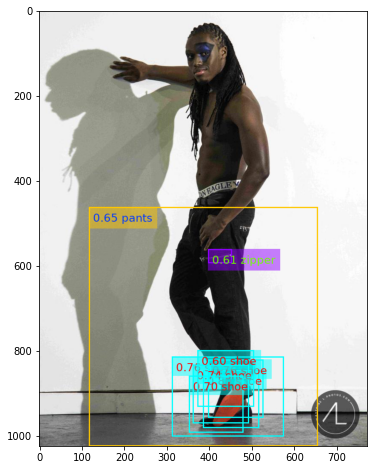

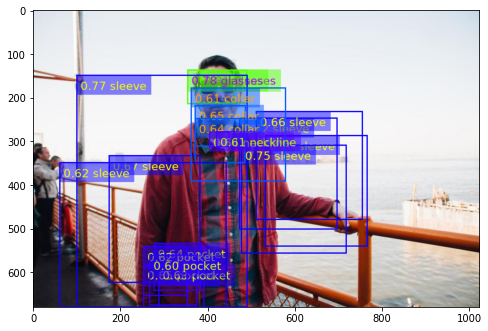

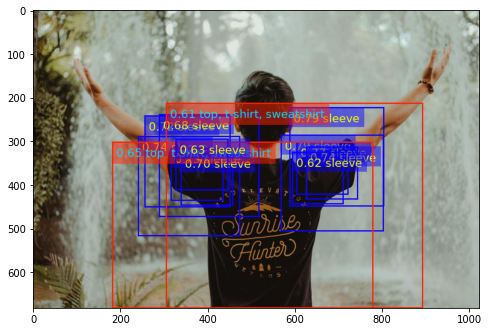

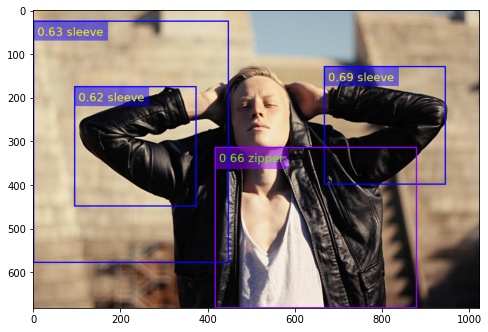

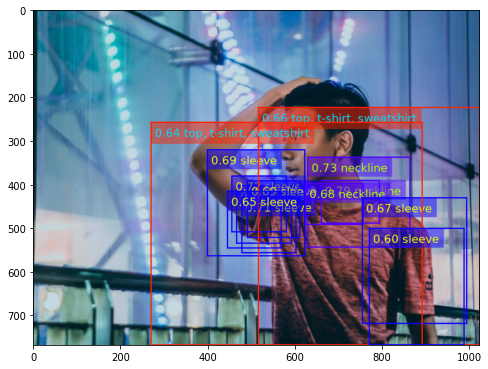

In [8]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

dataset= val_dataset_loader.dataset
score_thresh = 0.6
colors = random_colors(46)
model.eval()

for i, (inputs, targets) in enumerate(val_dataset_loader):
    results = model(inputs, targets)
    input, target = dataset[i]
    im = input['data']
    boxes = results['boxes'][0].detach().numpy()
    labels= results['labels'][0].detach().numpy()-1
    scores = results['scores'][0].detach().numpy()

    keep = scores > score_thresh
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    draw_plain_boxes(im, boxes)
    draw_single_image(im, boxes, scores, labels, colors, class_names=names)
    #heatmap = class_hp[fpn_layer][0].detach().numpy()
    #heatmap = centerness_hp[fpn_layer][0].detach().numpy()
    #mixim=visulize_colored_heatmaps_with_image(heatmap, im)
    plt.figure(figsize=(8,8))
    plt.imshow(im)

    if i>3:
        break

In [9]:
class_hp[1].shape

torch.Size([1, 46, 64, 50])

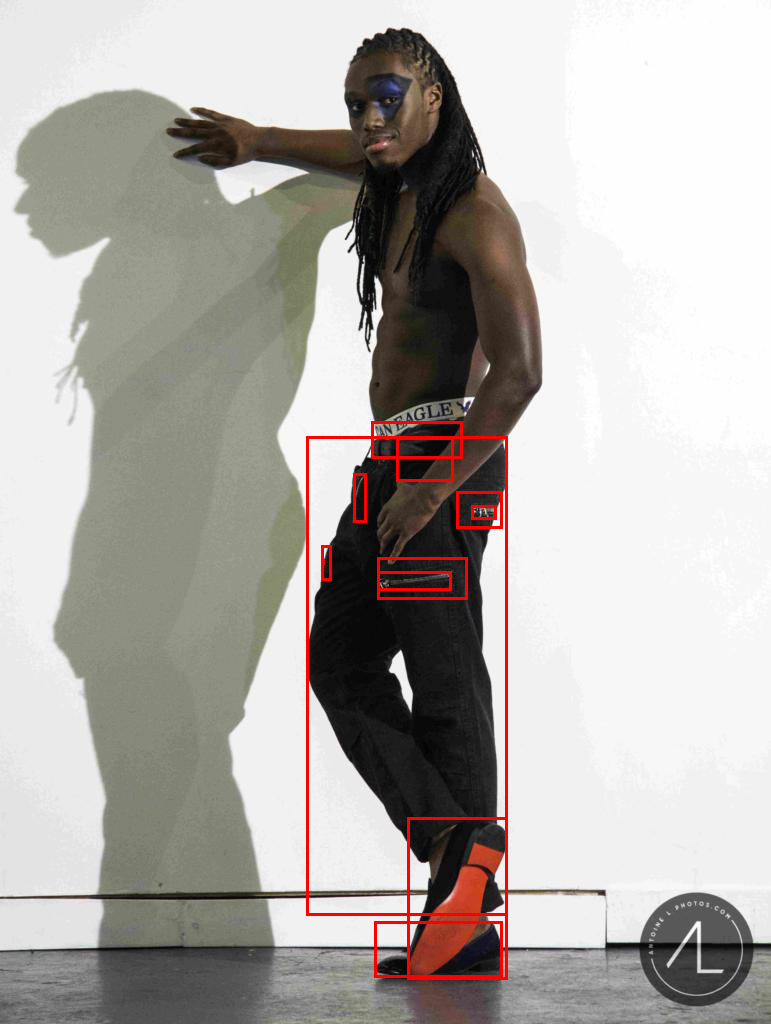

In [6]:
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
input, target = val_dataset_loader.dataset[0]
im = input['data']
boxes = target['boxes']
labels= target['labels']
draw_plain_boxes(im, boxes)
#heatmap = class_hp[0][0].detach().numpy()
#heatmap = centerness_hp[2][0].detach().numpy()
#mixim=visulize_colored_heatmaps_with_image(heatmap, im)
#plt.figure()
#plt.imshow(mixim)

#plt.imshow(im)

In [7]:
i=0
det_head.train()
det_head.center_sampling=True
for inputs, targets in val_dataset_loader:
    #print(inputs.keys())
    feature = backbone(inputs['data'])
    out_neck = neck(feature)
    #out_neck['p1'] = out_neck.pop('1')
    #out_neck['p2'] = out_neck.pop('2')
    #out_neck['p3'] = out_neck.pop('3')
    pred_out = det_head.head(out_neck)
    losses = det_head(inputs, out_neck, targets)
    break
    i += 1
    if i >15:
        break

In [8]:
pred_out = list(pred_out.values())

In [9]:
import torch
dtype = pred_out[0][0].dtype
device = pred_out[0][0].device
feature_sizes = [p[0].size()[-2:] for p in pred_out]

feature_mesh = det_head.generate_meshgrids(feature_sizes, dtype, device)
concat_mesh = torch.cat(feature_mesh, dim=0)
mesh_per_level = [m.shape[0] for m in feature_mesh]
boxes = targets[0]['boxes']
labels = targets[0]['labels']
mesh = concat_mesh

boxes_targets_list, labels_targets_list = det_head.generate_single_image_target(boxes, labels, mesh, mesh_per_level, dtype, device)

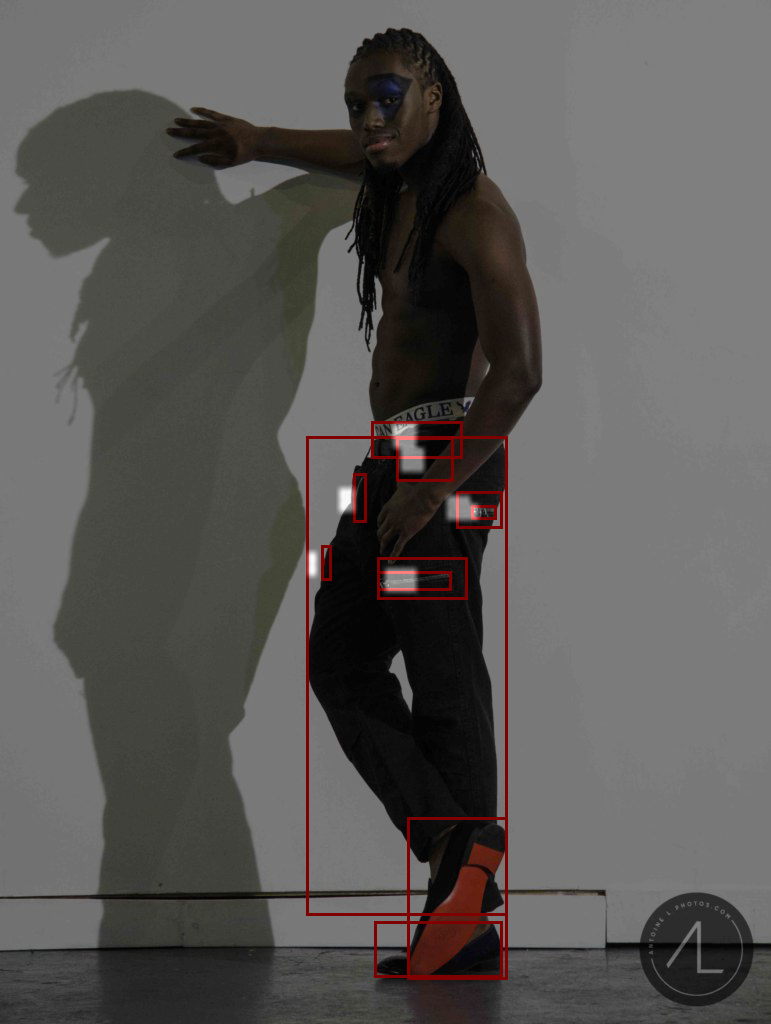

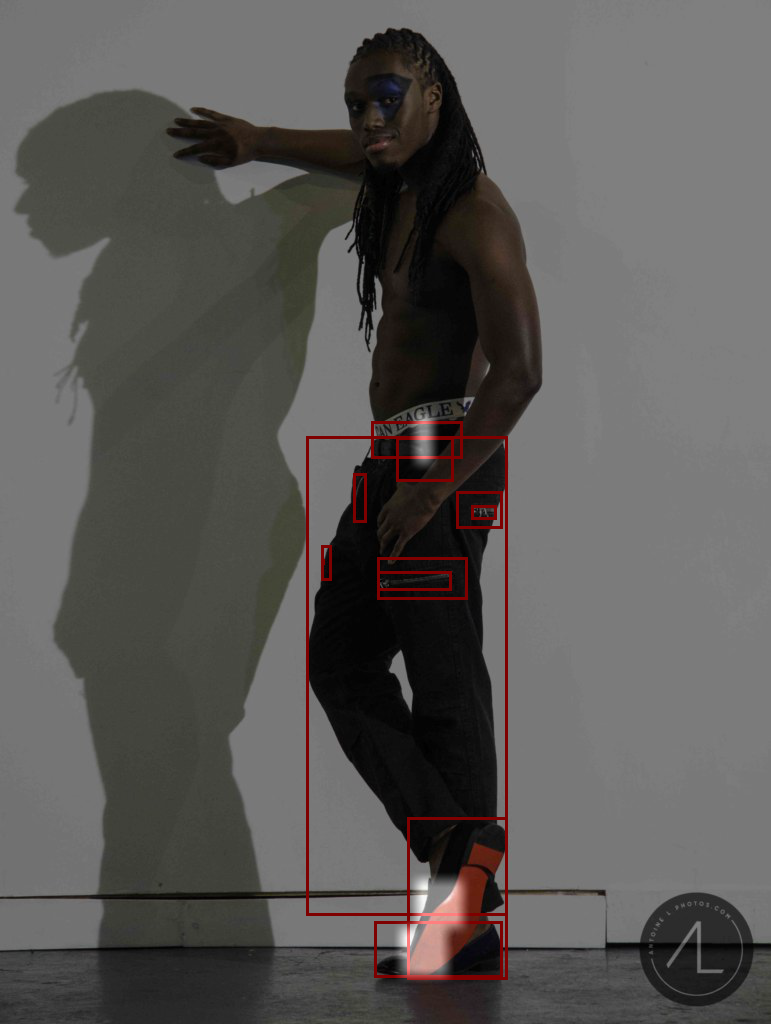

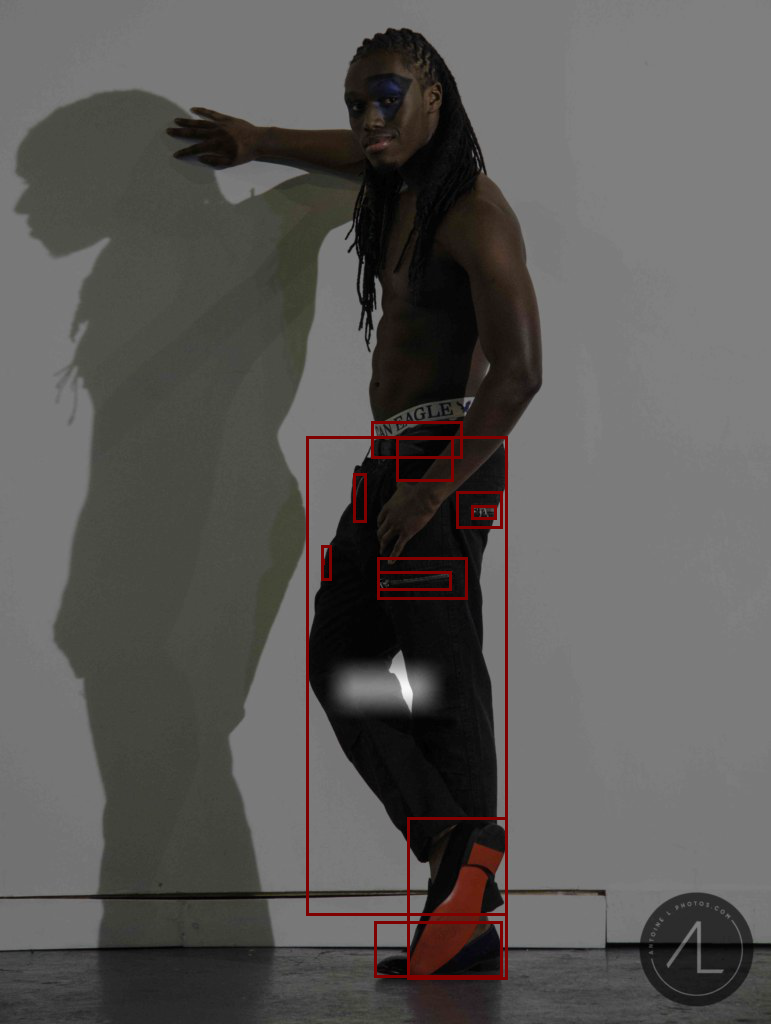

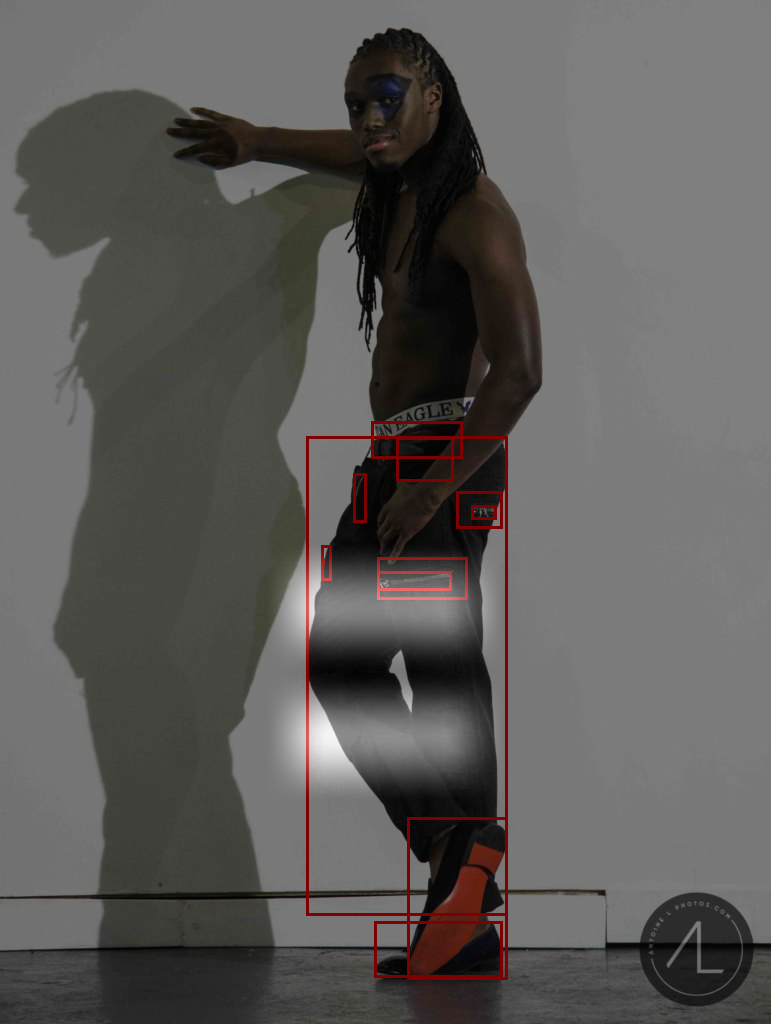

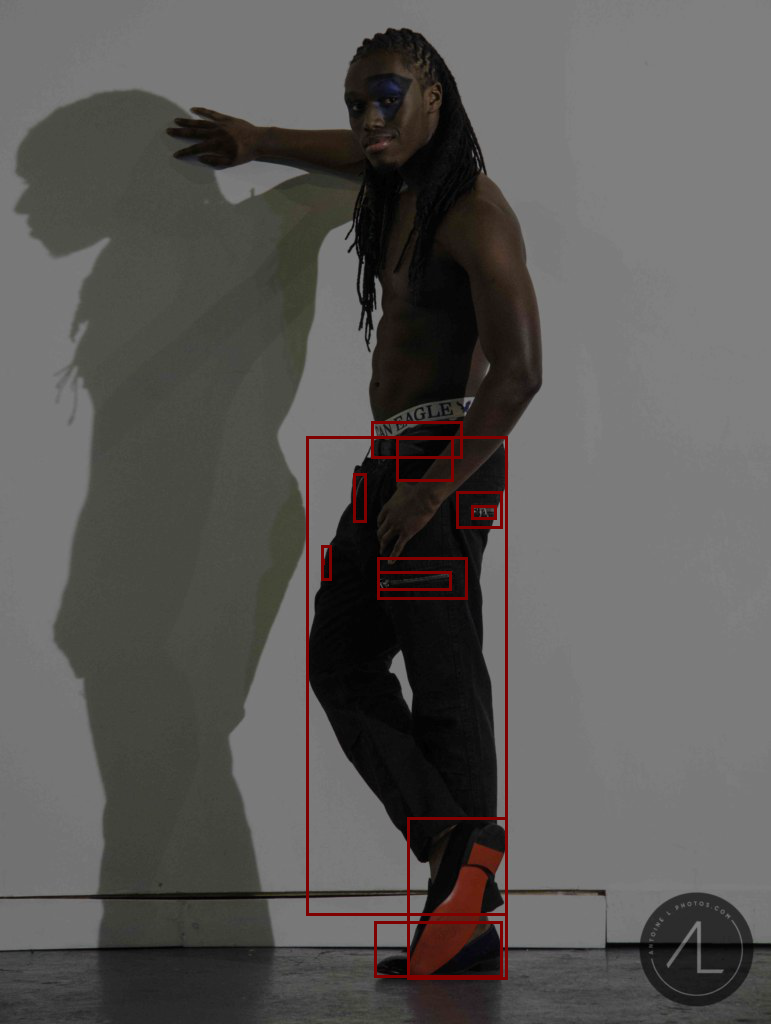

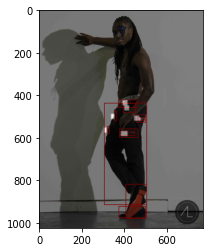

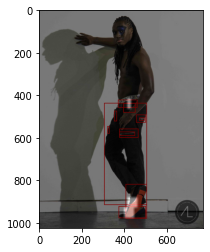

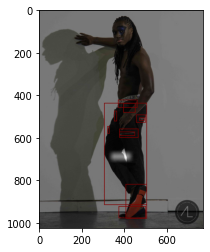

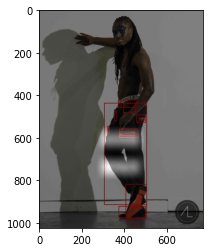

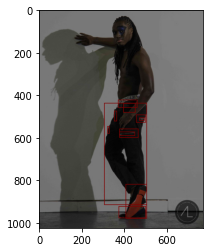

In [10]:
import matplotlib.pyplot as plt
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image
feature_sizes = [o[0].size()[-2:] for o in pred_out]
mesh_per_level = [mesh.size(0) for mesh in feature_mesh]
start=0
for mesh_num, im_shape in zip(mesh_per_level, feature_sizes):
    end = start+mesh_num
    labels_targets = labels_targets_list[start:end]
    bit_im = (labels_targets.reshape(im_shape)!=1000000).numpy()
    #print(bit_im.shape)
    #print(im.size)
    mixim = visulize_heatmaps_with_image(bit_im[None], im)
    plt.figure()
    plt.imshow(mixim)
    start = end

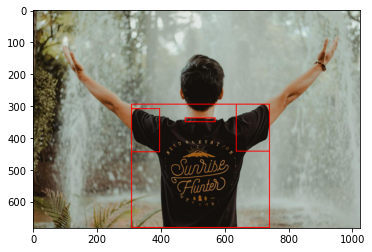

In [115]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
import matplotlib.pyplot as plt
dataset= val_dataset_loader.dataset
input, target = dataset[2]
im = input['data']
boxes = target['boxes']
labels= target['labels']
draw_plain_boxes(im, boxes)

plt.imshow(im)

In [61]:
target

{'boxes': array([[377., 557., 467., 599.],
        [377., 571., 451., 590.],
        [456., 491., 502., 528.],
        [471., 505., 496., 519.],
        [353., 473., 366., 522.],
        [321., 545., 331., 580.],
        [321., 559., 324., 564.],
        [396., 437., 453., 481.],
        [407., 817., 507., 979.],
        [374., 921., 502., 977.],
        [306., 436., 507., 915.],
        [371., 421., 462., 458.]], dtype=float32),
 'cat_labels': array([33, 36, 33, 36, 36, 33, 36, 33, 24, 24,  7, 20]),
 'labels': array([33, 36, 33, 36, 36, 33, 36, 33, 24, 24,  7, 20]),
 'image_id': 13297}

In [91]:
import torch
feature_sizes = [o[0].size()[-2:] for o in out.values()]
strides = [8, 16, 32, 64, 128]
regress_ranges = ((-1,64),(64,128),(128,256),(256,512),(512,10000000))
dtype = out['2'][0].dtype
device='cpu'
feature_mesh =det_head.generate_meshgrids(feature_sizes, dtype, device)
concat_mesh = torch.cat(feature_mesh, dim=0)
#meshs = det_head.generate_single_meshgrids(feature_sizes[0], strides[0], dtype=dtype, device=device)

In [74]:
boxes = [t['boxes'] for t in targets]
labels = [t['labels'] for t in targets]
lt, bt = det_head.generate_targets(feature_sizes, boxes, labels, dtype=feature['2'][0].dtype, device='cpu' )

tensor(261)


In [42]:
import torch
area = [torch.maximum((b[:,2]-b[:,0]),(b[:,3]-b[:,1])) for b in boxes]

In [43]:
area

[tensor([ 90.,  74.,  46.,  25.,  49.,  35.,   5.,  57., 162., 128., 479.,  91.]),
 tensor([ 99.,  52.,  52., 439.,  68., 118., 373., 125., 171., 126., 232., 472.,
         371., 354.]),
 tensor([434., 137., 149.,  96.])]

In [26]:
labels

[tensor([33, 36, 33, 36, 36, 33, 36, 33, 24, 24,  7, 20]),
 tensor([14,  2, 34,  1, 33, 29, 36, 33, 32, 33, 28,  5, 32, 36]),
 tensor([ 2, 32, 32, 34])]

In [24]:
sum([l.sum() for l in labels])

tensor(799)

In [64]:
lt[0]!=1000000

tensor([1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000,       7,       7, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000,       7,      36, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000,       7,       7, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000,       7,      24, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000,      24, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
        1000000, 1000000,       5,      28,      32, 1000000, 1000000, 1000000,
        1000000, 1000000,       5,      28,      32, 1000000, 1000000, 1000000,
        1000000, 1000000,      33,      

In [60]:
%%timeit
from torchcore.dnn.networks.detection_heads.fcos_head import multi_apply
mesh_per_level = [12800, 3200, 800, 208, 56]
bbox_list, label_targets_list = multi_apply(det_head.generate_single_image_target, boxes, labels, mesh=concat_mesh, mesh_per_level=mesh_per_level, dtype=dtype, device=device)

25.1 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
from torchcore.dnn.networks.detection_heads.fcos_head import multi_apply
mesh_per_level = [12800, 3200, 800, 208, 56]
bbox_list = []
label_targets_list = []
for box, label in zip(boxes, labels):
    a, b = det_head.generate_single_image_target(box, label, concat_mesh, mesh_per_level,dtype=dtype, device=device)
    bbox_list.append(a)
    label_targets_list.append(b)

In [65]:
mesh_per_level = [12800, 3200, 800, 208, 56]
det_head.generate_single_image_target(targets[0]['boxes'], targets[0]['labels'], concat_mesh, mesh_per_level, dtype=feature['2'][0].dtype,device='cpu')

NameError: name 'concat_mesh' is not defined

In [7]:
from collections import namedtuple
from typing import Any

import torch


# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for model with dict/list rvalues.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        Init call.
        """
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        """
        Wrap forward call.
        """
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data


In [8]:
head_new = ModelWrapper(head)

In [11]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('test_run')
writer.add_graph(head_new, out_neck)
writer.close()

/home/dsv/qida0163/anaconda3/envs/py38/lib/python3.8/site-packages/torch/jit/_trace.py:152: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if a.grad is not None:


In [5]:
from torchviz import make_dot
#make_dot(y.mean(), params=dict(model.named_parameters()))
make_dot(out['1'], params=dict(list(head.named_parameters()))).render("head_torchviz", format="png")

'head_torchviz.png'

In [12]:
out.keys()

odict_keys(['p5', 'p6', 'p7', 'p1', 'p2', 'p3'])

In [8]:
for k,v in out.items():
    print('{}:{}'.format(k, v[0].shape))

2:torch.Size([1, 46, 128, 100])
3:torch.Size([1, 46, 64, 50])
p5:torch.Size([1, 46, 32, 25])
p6:torch.Size([1, 46, 16, 13])
p7:torch.Size([1, 46, 8, 7])


In [6]:
import tqdm
import time
for i in tqdm.tqdm(range(100), desc='Training',bar_format="{l_bar}{bar:5}{r_bar}{bar:-5b}"):
    time.sleep(0.1)

Training: 100%|█████| 100/100 [00:10<00:00,  9.88it/s]     
